In [ ]:
# Start by importing all the things we'll need.
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import numpy as np
import os
import time
import shutil

import pandas as pd
import numpy as np
import string, os 
tf.__version__
from attention import AttentionLayer

In [1]:
df = pd.read_csv("data_news.csv")
df.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,bollywood,Raju Chacha
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?


In [2]:
def process(sent):
    string=re.sub(r'\([^)]*\)', ' ', sent)
    string=re.sub(r'\[[^)]*\]', ' ', string)
    string=string.replace("\n"," ")
    string=string.strip()
    string=re.sub('[^.a-zA-Z]',' ',string)
    string=string.lower()
    return string

In [3]:
df['processed_news']=df['headline_text'].apply(process)
df.head()

,publish_date,headline_category,headline_text,processed_news
0,20010101,sports.wwe,win over cena satisfying but defeating underta...,win over cena satisfying but defeating underta...
1,20010102,bollywood,Raju Chacha,raju chacha
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...,status quo will not be disturbed at ayodhya s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit,fissures in hurriyat over pak visit
4,20010102,unknown,America's unwanted heading for India?,america s unwanted heading for india


In [4]:
string_list=[]
for i in df['processed_news'].values:
    length=len(i.split())
    if(length>12):
        string_list.append(i)

In [5]:
len(string_list)

94708

In [1]:
"""
import pandas as pd
import re
import numpy as np
import tensorflow as tf
file = open("demo_text.txt","r") 
string=file.read()

string=re.sub(r'\([^)]*\)', '', string)
string=re.sub(r'\[[^)]*\]', '', string)
string=string.replace("\n","")
string=string.strip()
string=re.sub('[^.a-zA-Z]',' ',string)
string=string.lower()
string_list=string.split(".")
"""

In [18]:
corpus=" ".join(string_list)
corpus=corpus+" "+"<start>"+" "+"<end>"
corpus_words=corpus.split()
corpus_set=list(set(sorted(corpus_words)))
len(corpus_set)

26465

In [19]:
word_to_index= {word: index for (index, word) in enumerate(corpus_set)}
index_to_word = {index: word for (word, index) in word_to_index.items()}

In [20]:
def generate_dataset():
    X_data=[]
    Y_data=[]

    for sent in string_list:
        for i in range(len(sent.split())):
            X=['<start> ']+ sent.split()[:i+1] + [' <end>']
            X=" ".join(X)
            Y=['<start> ']+ sent.split()[i+1:] + [' <end>']
            Y=" ".join(Y)
            X_data.append(X)
            Y_data.append(Y)

    data=pd.DataFrame()
    data["input"]=X_data
    data["output"]=Y_data
    
    return data

def encode_string(string):
    encoded_list=[]
    raw_words=string.split()
    for word in raw_words:
        idx=word_to_index[word]
        encoded_list.append(idx)
        
    return encoded_list

def pad_sequences(input_list, max_len):
    pads=max_len-len(input_list)
    zero_seq=[0]*pads
    input_list.extend(zero_seq)
    return input_list    

In [21]:
data=generate_dataset()
data.head()

,input,output
0,<start> dancing <end>,<start> is a pleasure but give us hot food an...
1,<start> dancing is <end>,<start> a pleasure but give us hot food and w...
2,<start> dancing is a <end>,<start> pleasure but give us hot food and wat...
3,<start> dancing is a pleasure <end>,<start> but give us hot food and water say ar...
4,<start> dancing is a pleasure but <end>,<start> give us hot food and water say artist...


In [22]:
data['encoded_input']=data['input'].apply(encode_string)
data['encoded_output']=data['output'].apply(encode_string)

In [23]:
data.head()

,input,output,encoded_input,encoded_output
0,<start> dancing <end>,<start> is a pleasure but give us hot food an...,"[22342, 5702, 23161]","[22342, 13389, 16238, 21711, 15314, 14516, 199..."
1,<start> dancing is <end>,<start> a pleasure but give us hot food and w...,"[22342, 5702, 13389, 23161]","[22342, 16238, 21711, 15314, 14516, 19903, 121..."
2,<start> dancing is a <end>,<start> pleasure but give us hot food and wat...,"[22342, 5702, 13389, 16238, 23161]","[22342, 21711, 15314, 14516, 19903, 12174, 151..."
3,<start> dancing is a pleasure <end>,<start> but give us hot food and water say ar...,"[22342, 5702, 13389, 16238, 21711, 23161]","[22342, 15314, 14516, 19903, 12174, 15180, 523..."
4,<start> dancing is a pleasure but <end>,<start> give us hot food and water say artist...,"[22342, 5702, 13389, 16238, 21711, 15314, 23161]","[22342, 14516, 19903, 12174, 15180, 5239, 2508..."


In [24]:
max_length_input=max([len(i) for i in data.encoded_input.values])
max_length_output=max([len(i) for i in data.encoded_output.values])

In [25]:
input_data=[i for i in data.encoded_input.values]
output_data=[i for i in data.encoded_output.values]

In [26]:
data['padded_input']=data['encoded_input'].apply(lambda x: pad_sequences(x, max_length_input))
data['padded_output']=data['encoded_output'].apply(lambda x: pad_sequences(x, max_length_output))

In [27]:
import numpy as np
import tensorflow as tf
padded_input=np.array([i for i in data.padded_input.values])
padded_output=np.array([i for i in data.padded_output.values])

In [28]:
target_data = [[padded_output[n][i+1] for i in range(len(padded_output[n])-1)] for n in range(len(padded_output))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=max_length_output, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

In [17]:
p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

TypeError: only integer scalar arrays can be converted to a scalar index

In [29]:
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(word_to_index.keys())
vocab_out_size = len(word_to_index.keys())

In [30]:
print(vocab_in_size)

26465

In [33]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(max_length_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Use this if you dont need Bidirectional LSTM
# encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
# encoder_out, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))

encoder_lstm = Bidirectional(CuDNNLSTM(units=units, return_sequences=True, return_state=True))
encoder_outputs, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = LSTM(units=units*2, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)


# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([
    decoder_outputs, attn_out])


# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_outputs))))


# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
# Adam is used because it's, well, the best.

model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 27)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 27, 300)      7939500     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional (Bidire

In [ ]:
# Note, we use 20% of our data for validation.
epochs = 10
history = model.fit([input_data, padded_output], target_data,
                 batch_size= BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)

Train on 282066 samples, validate on 70517 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
 12032/282066 [>.............................] - ETA: 2:46:24 - loss: 3.5068 - sparse_categorical_accuracy: 0.7015

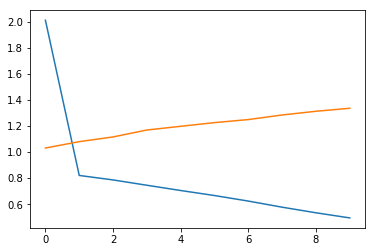

In [24]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [26]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [45]:
# Converts the given sentence (just a string) into a vector of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence):

    pre = sentence
    vec = np.zeros(max_length_input)
    sentence_list = [word_to_index[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = word_to_index["<start>"]
    stop_vec = word_to_index["<end>"]
    
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (max_length_output-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = index_to_word[np.argmax(nvec[0,0])]
    return output_sentence

In [64]:
#Note that only words that we've trained the model on will be available, otherwise you'll get an error.


test = [
    'jose is the',
    'he is',
    'artificial'
]

import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))

,Input seq,Pred. Seq
0,jose is the,the agent
1,he is,the agent
2,artificial,the agent
